In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from datasets import load_metric

### Load data

In [2]:
def load_medical_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['text'].tolist()
    labels = df['label'].tolist()
    return texts, labels


# dataset class
class LiteratureDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

data_file = "../Data/raw_data/raw_combined_2.csv"
texts, labels = load_medical_data(data_file)



### Train model

In [3]:

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Avg Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss}")


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)




train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.333, random_state=42)

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, output_attentions=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# prepare datasets and dataloaders
train_dataset = LiteratureDataset(train_texts, train_labels, tokenizer, max_len=256)
val_dataset = LiteratureDataset(val_texts, val_labels, tokenizer, max_len=256)
test_dataset = LiteratureDataset(test_texts, test_labels, tokenizer, max_len=256)

print(f"Train dataset size: {len(train_dataset)}", f"Val dataset size: {len(val_dataset)}", f"Test dataset size: {len(test_dataset)}", sep='\n')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# train
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ibrahim/anaconda3/envs/distilbert_env/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train dataset size: 1398
Val dataset size: 400
Test dataset size: 200


Epoch 1/1: 100%|██████████| 88/88 [05:01<00:00,  3.43s/it, loss=0.0224]


Epoch 1, Avg Loss: 0.2129162472291765, Val Loss: 0.02266528896987438


### Test model

In [4]:

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

test_model(model, test_loader, device)


Testing: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]

Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0, 1.0)

### Example inputs

In [5]:
#new_text = "In this study, we presented a novel conjugation chemistry for developing enhanced KPC2 enzyme testing at POC settings using SPEs-based electrochemical immunoassay [44]. Our approach relied on a site-directed reaction that used a heterobifunctional PEG polymer to link oxidized polyclonal anti-KPC2 antibodies to the surface of Au-SPEs. We achieved PEGylation of the Au-SPE using SH-PEG-hydrazide, which left the hydrazide groups free to react with the oxidized Fc regions of anti-KPC2 polyclonal antibodies. Our results demonstrated that this site-directed conjugation approach offered a viable alternative to traditional NHS-based chemistry for the modification of Au-SPEs with antibodies. By using directional conjugation, we were able to obtain highly efficient and specific binding of the antibody to the enzyme, which is crucial for designing and developing accurate detection of KPC2."


new_text ="This paper presents a novel method on building relationship between the vision features of the terrain images and the terrain traversability which manifests the difficulty of field robot traveling across one terrain. Vision features of the image are extracted based on color and texture. The travesability is labeled with the relative vibration. The support vector machine regression method is adopted to build up the inner relationship between them. In order to avoid the over-learning during training, k-fold method is used and average mean square error is defined as the target minimized to get the optimal parameters based on parameter space grid method. For the traveling smoothness of field robot, the original traversability prediction is transformed to computed traversability prediction based on different initial sub-regions. The optimal path is given by minimizing the sum of computed traversability prediction of all sub-regions in each path. Three experiments are discussed to demonstrate the effectiveness and efficiency of the method mentioned in this paper."



### Inference

In [6]:
def predicted_text(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # tokenise the input text
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    num_tokens = len(tokens)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
        logits = outputs.logits
        print(logits)
        predicted_class = torch.argmax(logits, dim=1).item()
        prediction = "Medical" if predicted_class == 1 else "Non-Medical"
    return prediction
predicted_text(model, tokenizer, new_text, device)

tensor([[ 1.9416, -1.8969]])


'Non-Medical'

### Get attention map

tensor([[-1.4501,  1.8074]])


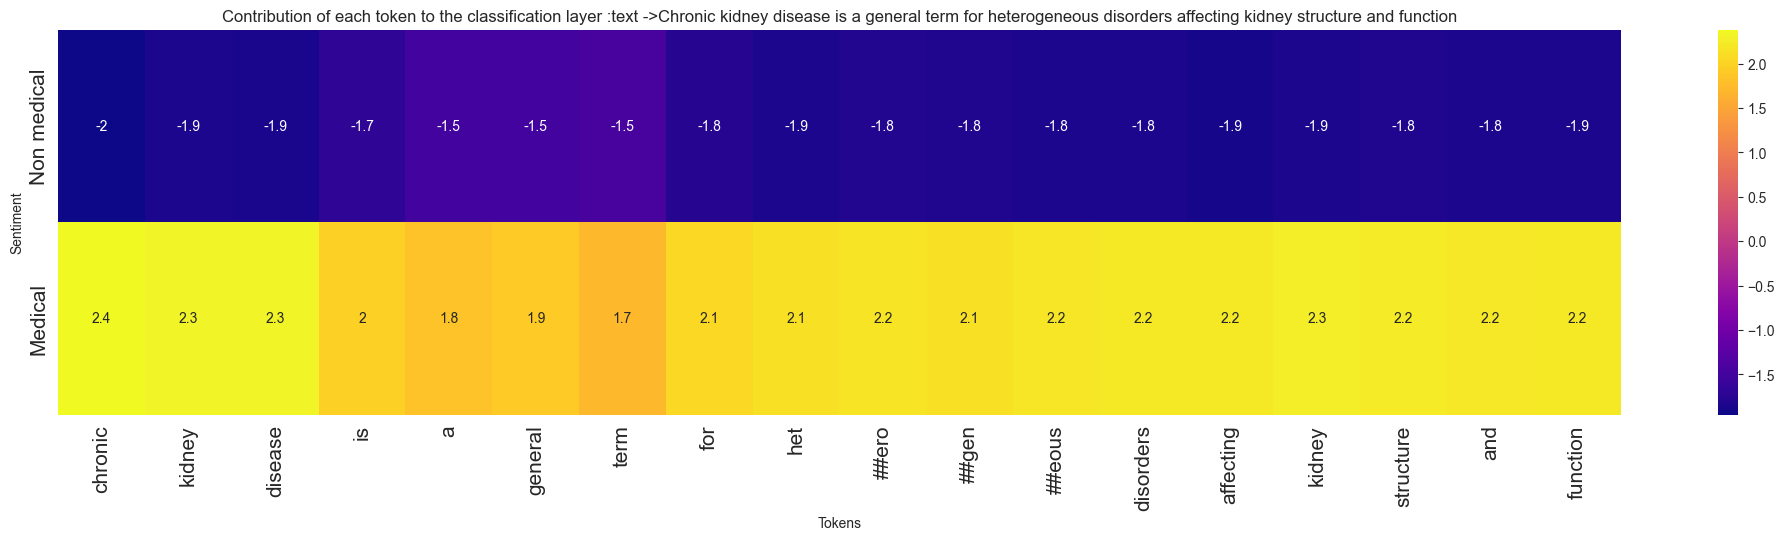

In [7]:
def get_attentions_token(model, tokenizer, text, device):
    model.eval()

    # tokenise  input text
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    num_tokens = len(tokens)

    # forward pass to get hidden states and attentions
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    print(outputs.logits)
    # get last hidden state and pass it through the pre-classifier and classifier
    last_hidden_state = outputs.hidden_states[-1].squeeze(0)
    pre_c = model.pre_classifier(last_hidden_state)
    classifie = model.classifier(pre_c).cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(num_tokens*1.4, 5))

    # plot heatmap
    sns.heatmap(classifie.T, cmap='plasma', xticklabels=tokens, yticklabels=['Non medical','Medical'], annot=True)
    plt.title(f"Contribution of each token to the classification layer :text ->{text}")
    plt.xlabel("Tokens")
    plt.ylabel("Sentiment")
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

    fig.savefig('attention.png')

get_attentions_token(model, tokenizer, "Chronic kidney disease is a general term for heterogeneous disorders affecting kidney structure and function", device)

In [13]:
# Assuming the data file for waste burning classification is named 'waste_burning_data.csv'
# and it has the same format with 'text' and 'label' columns.

def load_waste_burning_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['text'].tolist()
    labels = df['label'].tolist()
    return texts, labels

# Load the new data
data_file = "../../Data/cleaned_data/waste_combined.csv" 
texts_waste, labels_waste = load_waste_burning_data(data_file)


In [14]:
# Split the data into training, validation, and test sets
train_texts_waste, test_texts_waste, train_labels_waste, test_labels_waste = train_test_split(
    texts_waste, labels_waste, test_size=0.3, random_state=42)

val_texts_waste, test_texts_waste, val_labels_waste, test_labels_waste = train_test_split(
    test_texts_waste, test_labels_waste, test_size=0.333, random_state=42)


In [15]:
# Prepare datasets and dataloaders for the new data
train_dataset_waste = LiteratureDataset(train_texts_waste, train_labels_waste, tokenizer, max_len=256)
val_dataset_waste = LiteratureDataset(val_texts_waste, val_labels_waste, tokenizer, max_len=256)
test_dataset_waste = LiteratureDataset(test_texts_waste, test_labels_waste, tokenizer, max_len=256)

print(f"Train dataset size: {len(train_dataset_waste)}",
      f"Val dataset size: {len(val_dataset_waste)}",
      f"Test dataset size: {len(test_dataset_waste)}", sep='\n')

train_loader_waste = DataLoader(train_dataset_waste, batch_size=16, shuffle=True)
val_loader_waste = DataLoader(val_dataset_waste, batch_size=16, shuffle=False)
test_loader_waste = DataLoader(test_dataset_waste, batch_size=16, shuffle=False)


Train dataset size: 8
Val dataset size: 2
Test dataset size: 2


In [16]:
# We continue training the same model on the new data
# Set up optimizer and criterion
optimizer_waste = AdamW(model.parameters(), lr=2e-5)
criterion_waste = nn.CrossEntropyLoss()

# Train the model on the new data
train_model(model, train_loader_waste, val_loader_waste, optimizer_waste, criterion_waste, device, epochs=1)


/Users/ibrahim/anaconda3/envs/distilbert_env/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/1: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, loss=0.317]

Epoch 1, Avg Loss: 0.31700772047042847, Val Loss: 1.929450273513794


In [17]:
# Test the model on the new test set
test_model(model, test_loader_waste, device)


Testing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]

Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0, 1.0)

In [19]:
# Example input text for waste burning classification
new_text_waste = "The emission of pollutants from the incineration of municipal waste poses significant environmental and health risks."

# Predict the class of the new text
prediction = predicted_text(model, tokenizer, new_text_waste, device)
print(f"Prediction: {prediction}")


tensor([[-0.0998,  0.4809]])
Prediction: Medical


tensor([[-0.0998,  0.4809]])


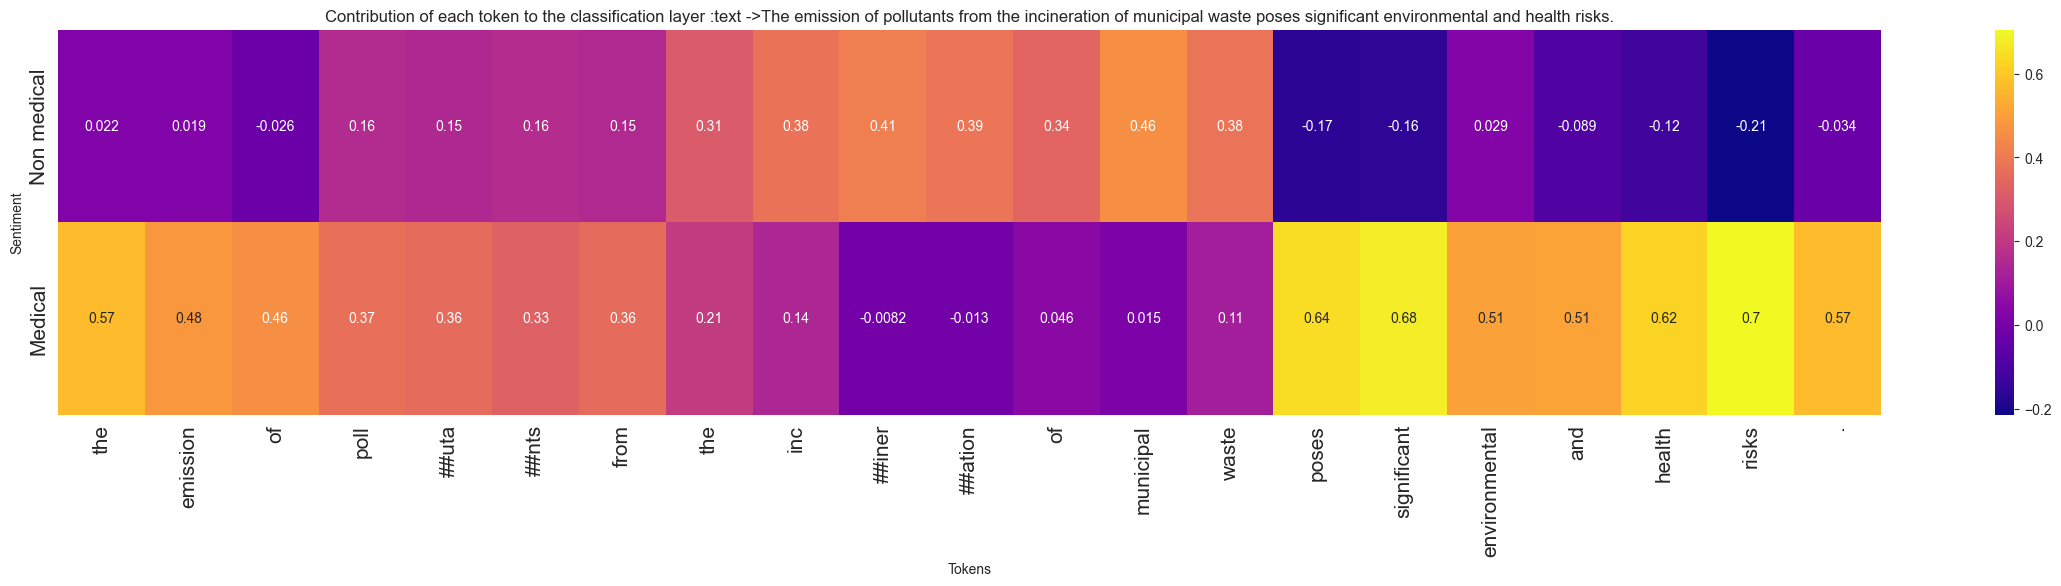

In [20]:
# Visualize the attention map for the example input
get_attentions_token(model, tokenizer, new_text_waste, device)
